In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import h5py
import seaborn as sns
import os
import surfplot
import nibabel as nib
import h5py
import scipy.stats as stats
import sklearn.svm as svm
import pickle
import sklearn
from neuromaps.datasets import fetch_fslr
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import binomtest
%matplotlib inline

# obtain glassier template

glasser_atlas_str= "/Users/xiaoxuan/Desktop/mess_folders/202406_fMRI/data/Glasser_LR_Dense64k.dlabel.nii"
glasser_atlas = nib.load(glasser_atlas_str).get_fdata()[0].astype(int)
print(glasser_atlas.shape)

(64984,)


In [11]:
map_df_lh = pd.read_excel("/Users/xiaoxuan/Desktop/mess_folders/202406_fMRI/data/Glasser_2016_Table.xlsx")
map_df_lh = map_df_lh.iloc[:,0:2]


# Insert row with region 0
map_df_lh.loc[-1] = [0, 'LG'] # ? region 0 as the white matter/subcortex?
map_df_lh.index = map_df_lh.index + 1  # shifting index
map_df_lh = map_df_lh.sort_index().reset_index(drop=True)

# # Rename columns
map_df_lh.columns = ['region_id', 'region_name']


# # Ensure region_id is numeric
map_df_lh['region_id'] = pd.to_numeric(map_df_lh['region_id'], errors='coerce')

# # Copy the left hemisphere DataFrame for the right hemisphere
map_df_rh = map_df_lh.copy()

# # Increase map_df_rh region_id by 180 and index by 180
map_df_rh['region_id'] = map_df_rh['region_id'] + 180
map_df_rh.index = map_df_rh.index + 180

# # Concatenate both hemispheres
map_df = pd.concat([map_df_lh, map_df_rh], axis=0).reset_index(drop=True)

mapped_atlas = {}

for id, name in zip(map_df['region_id'], map_df['region_name']):
    # indexes of id in glasser_atlas
    if str(name) not in mapped_atlas.keys():
        mapped_atlas[str(name)] = np.where(glasser_atlas == id)[0]
    else:
        mapped_atlas[str(name)] = np.concatenate((mapped_atlas[str(name)], np.where(glasser_atlas == id)[0]))


In [37]:
# read the data
base_dir = "/Users/xiaoxuan/Desktop/mess_folders/202406_fMRI/data/feature_decoding_results"
tasks = ["1back", "interdms", "ctxdm"]
is_normalized = False
features = ["location","category"]
num_regions = 360
unique_stims = 2
significant_brains = {}
significant_brains_fdr = {}


def print_hdf5_structure(file, indent=0):
    """
    Recursively print the structure of an HDF5 file.
    """
    for key in file.keys():
        item = file[key]
        print('    ' * indent + f"{key}: {type(item)}")
        if isinstance(item, h5py.Group):
            print_hdf5_structure(item, indent + 1)
        elif isinstance(item, h5py.Dataset):
            print('    ' * (indent + 1) + f"Shape: {item.shape}, Data type: {item.dtype}")


for task in tasks:
    file_path = os.path.join(base_dir, "%s_decoding_method_distance_sub-03_is_normalzied_%s.pkl" % (task, str(is_normalized)))
    
    # Load from pickle file
    with open(file_path, 'rb') as f:
        loaded_data = pickle.load(f)
    for subtask in loaded_data.keys():
        significant_brains[subtask] = {}
        significant_brains_fdr[subtask] = {}
        
        for feature in loaded_data[subtask].keys():
            
            significant_brains[subtask][phase] = {}
            significant_brains_fdr[subtask][phase] = {}
            
            for feature in loaded_data[subtask][phase].keys():
                
                
                perm_decoding_accuracy = loaded_data[subtask][phase][feature]["perm_decoding_accuracy"]
                decoding_accuracy = loaded_data[subtask][phase][feature]["decoding_accuracy"]
                binary_decoding_accuracy = loaded_data[subtask][phase][feature]["binary_decoding_accuracy"]

                
                stats_decoding = np.zeros((num_regions,3,))
                # Calculate accuracy and p-values
                for region in range(num_regions):
                    try:
                        acc = np.mean(binary_decoding_accuracy[region])
                        p = binomtest(np.sum(binary_decoding_accuracy[region]), n=len(binary_decoding_accuracy[region]), p=1/unique_stims, alternative='greater')
                        stats_decoding[region, 0] = acc
                        stats_decoding[region, 1] = p.pvalue
                    except:
                        stats_decoding[region, 0] = 0
                        stats_decoding[region, 1] = 1
                        continue
                # Perform FDR correction
                q = fdrcorrection(stats_decoding[:, 1])[1]
                stats_decoding[:, 2] = q
                #### todo: include conditions * brain regions for fdr correction


                # identify brain regions that are significantly decodable
                # after fdr correction
                fdr_region_indices = np.where(stats_decoding[:, 2] < 0.05)[0]
                significant_brains_fdr[subtask][phase][feature] = fdr_region_indices
                # before fdr correction
                region_indices = np.where(stats_decoding[:, 1] < 0.05)[0]
                significant_brains[subtask][phase][feature] = region_indices


In [38]:
print(significant_brains)

{'1backloc': {'category': {'late_delay': array([ 18,  42,  46, 104, 138, 152, 191, 239, 306, 334, 335, 342, 354])}}, '1backctg': {'category': {'late_delay': array([ 18,  22,  28,  47,  50,  57,  84,  86, 106, 114, 131, 149, 175,
       180, 183, 210, 220, 230, 238, 243, 275, 281, 293, 307, 321, 356,
       358])}}, '1backobj': {'category': {'late_delay': array([ 17,  64,  75, 108, 154, 165, 224, 231, 246, 329, 334])}}, 'interdmsctgABAB': {'category': {'late_delay': array([], dtype=int64)}}, 'interdmsobjABBA': {'category': {'late_delay': array([], dtype=int64)}}, 'interdmsctgABBA': {'category': {'late_delay': array([], dtype=int64)}}, 'interdmsobjABAB': {'category': {'late_delay': array([], dtype=int64)}}, 'interdmslocABBA': {'category': {'late_delay': array([], dtype=int64)}}, 'interdmslocABAB': {'category': {'late_delay': array([], dtype=int64)}}, 'ctxlco': {'category': {'late_delay': array([  6,   8,  25,  45,  65,  72,  77,  94,  95,  97, 112, 135, 152,
       192, 210, 219, 256, 26

In [39]:
# identify areas that consistently contain information about a specific feature regardless of task relevance or not. 
# From significance maps for each feature/task
# make a brain heatmap where the color would indicate the number of conditions (task-feature) that each area was found to be significant (e.g. 7/10); 

is_fdr_correction = False
phase = "early_delay"
if not is_fdr_correction:
    data = significant_brains
else:
    data = significant_brains_fdr

num_all_conditions = len(features) * len(data.keys())
significant_condition_per_region = np.zeros((1,num_regions)) # store the number of conditions (task-feature) that each area was found to be significant
for region in range(num_regions):
    for task in data.keys():
        for feature in data[task].keys():
        
           if region in data[task][feature][phase]:
               significant_condition_per_region[0,region] += 1

significant_condition_per_region = significant_condition_per_region.reshape(-1)/num_all_conditions
regions_with_significant_condition_ratio_positive = np.where(significant_condition_per_region > 0)[0]
# print(regions_with_significant_condition_ratio_positive)

filtered_df = map_df[map_df['region_id'].isin(regions_with_significant_condition_ratio_positive)]
# Extract the region names
region_names = filtered_df['region_name'].tolist()
print(region_names)

# visualization

surfaces = fetch_fslr()
lh, rh = surfaces['veryinflated']
surface_dat = np.zeros((len(glasser_atlas),))

for roi in range(num_regions):
    roi_ind = np.where(glasser_atlas==roi+1)[0]
    surface_dat[roi_ind] = significant_condition_per_region[roi]

p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
if not is_fdr_correction:
    fig.suptitle('[%s phase: percentage of \ntask-feature conditions that are significant \n before fdr correction]' % (phase),y=0.98,fontsize=14)
else:
    fig.suptitle('[%s phase: percentage of \ntask-feature conditions that are significant \n after fdr correction]' % (phase),y=0.98,fontsize=14)
fig.tight_layout()

KeyError: 'early_delay'

In [40]:
import plotly.graph_objects as go
from nilearn import datasets, plotting, surface

# Fetch the fsaverage surface dataset
surfaces = datasets.fetch_surf_fsaverage()

# Load the pial surfaces for left and right hemispheres
lh = surfaces['pial_left']
rh = surfaces['pial_right']

# Load surface mesh data
lh_coords, lh_faces = surface.load_surf_mesh(lh)
rh_coords, rh_faces = surface.load_surf_mesh(rh)

# Ensure the faces are integers and coordinates are floats
lh_faces = np.asarray(lh_faces, dtype=int)
rh_faces = np.asarray(rh_faces, dtype=int)
lh_coords = np.asarray(lh_coords, dtype=float)
rh_coords = np.asarray(rh_coords, dtype=float)

# Prepare surface data
surface_dat = np.zeros((len(glasser_atlas),))
for roi in range(num_regions):
    roi_ind = np.where(glasser_atlas == roi + 1)[0]
    surface_dat[roi_ind] = significant_condition_per_region[roi]

# Combine left and right hemisphere surfaces
combined_coords = np.vstack([lh_coords, rh_coords])
combined_faces = np.vstack([lh_faces, rh_faces + len(lh_coords)])

# Create an interactive plot with Plotly
fig = go.Figure()

# Add brain surface
fig.add_trace(go.Mesh3d(
    x=combined_coords[:, 0],
    y=combined_coords[:, 1],
    z=combined_coords[:, 2],
    i=combined_faces[:, 0],
    j=combined_faces[:, 1],
    k=combined_faces[:, 2],
    intensity=surface_dat,
    colorscale='Magma',
    colorbar=dict(title='percentage of significant conditions', titleside='right'),
    showscale=True
))

# Update layout for better visualization
fig.update_layout(
    title=f'{phase} phase: percentage of task-feature conditions that are significant',
    scene=dict(
        xaxis=dict(showbackground=False),
        yaxis=dict(showbackground=False),
        zaxis=dict(showbackground=False),
        aspectmode='auto'
    ),
    width=800,
    height=600
)

# Show the interactive plot
fig.show()


ValueError: shape mismatch: value array of shape (360,) could not be broadcast to indexing result of shape (827,)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

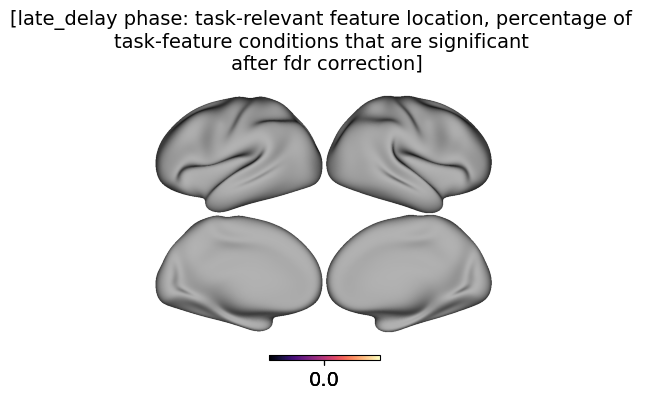

In [32]:
# areas that contain information about the task relevant feature regardless of what it is. 
# make a brain heatmap where the color would indicate the number of conditions that each area was found to be significant.

is_fdr_correction = True
phase = "late_delay"
task_feature = "location"
feature = task_feature

if not is_fdr_correction:
    data = significant_brains
else:
    data = significant_brains_fdr

num_all_conditions = len(features) * len(data.keys())
significant_condition_per_region = np.zeros((1,num_regions)) # store the number of conditions (task-feature) that each area was found to be significant
for region in range(num_regions):
    for task in data.keys():
        if task_feature == "location":
            if "loc" not in task:
                continue
        if task_feature == "category":
            if "ctg" not in task:
                continue
        if region in data[task][feature][phase]:
            significant_condition_per_region[0,region] += 1

significant_condition_per_region = significant_condition_per_region.reshape(-1)/num_all_conditions
print(significant_condition_per_region)
regions_with_significant_condition_ratio_positive = np.where(significant_condition_per_region > 0)[0]
# print(regions_with_significant_condition_ratio_positive)

filtered_df = map_df[map_df['region_id'].isin(regions_with_significant_condition_ratio_positive)]
# Extract the region names
region_names = filtered_df['region_name'].tolist()
print(region_names)

# visualization

surfaces = fetch_fslr()
lh, rh = surfaces['veryinflated']
surface_dat = np.zeros((len(glasser_atlas),))

for roi in range(num_regions):
    roi_ind = np.where(glasser_atlas==roi+1)[0]
    surface_dat[roi_ind] = significant_condition_per_region[roi]

p = surfplot.Plot(lh,rh,size=(500,350),zoom=1.8)
p.add_layer(surface_dat.T,cmap='magma',color_range=[np.min(surface_dat), np.max(surface_dat)])
fig = p.build(figsize=(4,4),colorbar=True,cbar_kws={'fontsize':14})
if not is_fdr_correction:
    fig.suptitle('[%s phase: task-relevant feature %s, percentage of \ntask-feature conditions that are significant \n before fdr correction]' % (phase, task_feature),y=0.98,fontsize=14)
else:
    fig.suptitle('[%s phase: task-relevant feature %s, percentage of \ntask-feature conditions that are significant \n after fdr correction]' % (phase, task_feature),y=0.98,fontsize=14)
fig.tight_layout()

In [33]:
import plotly.graph_objects as go
from nilearn import datasets, plotting, surface

# Fetch the fsaverage surface dataset
surfaces = datasets.fetch_surf_fsaverage()

# Load the pial surfaces for left and right hemispheres
lh = surfaces['pial_left']
rh = surfaces['pial_right']

# Load surface mesh data
lh_coords, lh_faces = surface.load_surf_mesh(lh)
rh_coords, rh_faces = surface.load_surf_mesh(rh)

# Ensure the faces are integers and coordinates are floats
lh_faces = np.asarray(lh_faces, dtype=int)
rh_faces = np.asarray(rh_faces, dtype=int)
lh_coords = np.asarray(lh_coords, dtype=float)
rh_coords = np.asarray(rh_coords, dtype=float)

# Prepare surface data
surface_dat = np.zeros((len(glasser_atlas),))
for roi in range(num_regions):
    roi_ind = np.where(glasser_atlas == roi + 1)[0]
    surface_dat[roi_ind] = significant_condition_per_region[roi]

# Combine left and right hemisphere surfaces
combined_coords = np.vstack([lh_coords, rh_coords])
combined_faces = np.vstack([lh_faces, rh_faces + len(lh_coords)])

# Create an interactive plot with Plotly
fig = go.Figure()

# Add brain surface
fig.add_trace(go.Mesh3d(
    x=combined_coords[:, 0],
    y=combined_coords[:, 1],
    z=combined_coords[:, 2],
    i=combined_faces[:, 0],
    j=combined_faces[:, 1],
    k=combined_faces[:, 2],
    intensity=surface_dat,
    colorscale='Magma',
    colorbar=dict(title='percentage of significant conditions', titleside='right'),
    showscale=True
))

# Update layout for better visualization
fig.update_layout(
    title=f'{phase} phase: task-relevant feature {task_feature}, percentage of task-feature conditions that are significant',
    scene=dict(
        xaxis=dict(showbackground=False),
        yaxis=dict(showbackground=False),
        zaxis=dict(showbackground=False),
        aspectmode='auto'
    ),
    width=800,
    height=600
)

# Show the interactive plot
fig.show()
